In [8]:
from bs4 import BeautifulSoup
import requests
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import classification_report
from scipy.spatial.distance import cdist
import matplotlib.colors as mcolors
import pickle
import warnings
warnings.filterwarnings('ignore')

# Getting the Billboard 100

In [2]:
r = requests.get('https://www.billboard.com/charts/hot-100/').content
soup = BeautifulSoup(r, 'html.parser')
# Using the code we developed to get the billboard100 in the web scraping lab
artists = soup.find_all("span", attrs={"class": "c-label a-no-trucate a-font-primary-s lrv-u-font-size-14@mobile-max u-line-height-normal@mobile-max u-letter-spacing-0021 lrv-u-display-block a-truncate-ellipsis-2line u-max-width-330 u-max-width-230@tablet-only"})
artists

N1_artist = soup.find_all('span', attrs = {'class' :"c-label a-no-trucate a-font-primary-s lrv-u-font-size-14@mobile-max u-line-height-normal@mobile-max u-letter-spacing-0021 lrv-u-display-block a-truncate-ellipsis-2line u-max-width-330 u-max-width-230@tablet-only u-font-size-20@tablet"})
artists = N1_artist + artists

artist_names = []
for artist in artists:
    artist_names.append(artist.get_text(strip = True))
    
    
songs = soup.find_all('h3', attrs={'class':"c-title a-no-trucate a-font-primary-bold-s u-letter-spacing-0021 lrv-u-font-size-18@tablet lrv-u-font-size-16 u-line-height-125 u-line-height-normal@mobile-max a-truncate-ellipsis u-max-width-330 u-max-width-230@tablet-only"})

N1_song = soup.find_all('h3', attrs={'class' :"c-title a-no-trucate a-font-primary-bold-s u-letter-spacing-0021 u-font-size-23@tablet lrv-u-font-size-16 u-line-height-125 u-line-height-normal@mobile-max a-truncate-ellipsis u-max-width-245 u-max-width-230@tablet-only u-letter-spacing-0028@tablet" })
songs = N1_song + songs

song_names = []
for song in songs:
    song_names.append(song.get_text(strip = True))

In [3]:
billboard100 = pd.DataFrame(zip(artist_names,song_names), columns = ['artist', 'song_name'])
billboard100.index = billboard100.index + 1
billboard100

,artist,song_name
1,Drake Featuring SZA,Slime You Out
2,Doja Cat,Paint The Town Red
3,SZA,Snooze
4,Luke Combs,Fast Car
5,Zach Bryan Featuring Kacey Musgraves,I Remember Everything
...,...,...
96,Olivia Rodrigo,Teenage Dream
97,Thomas Rhett,Angels Don't Always Have Wings
98,Bad Bunny,Where She Goes
99,Paul Russell,Lil Boo Thang


In [4]:
spot_df = pd.read_csv('spotify_files/spotify_df.csv')
spot_df.drop('Unnamed: 0', axis = 1, inplace = True)
spot_df

,artist,song_name,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,track_href,analysis_url,duration_ms,time_signature
0,Eve,What It's Like,spotify:track:6vUPPEN2V2lZ78b6DyEIjZ,0.679,0.557,0,-7.423,1,0.0281,0.090400,0.032400,0.0866,0.405,85.152,audio_features,6vUPPEN2V2lZ78b6DyEIjZ,https://api.spotify.com/v1/tracks/6vUPPEN2V2lZ...,https://api.spotify.com/v1/audio-analysis/6vUP...,303133,4
1,Eve,Kaikai Kitan,spotify:track:6y4GYuZszeXNOXuBFsJlos,0.584,0.911,5,-3.515,0,0.0900,0.011900,0.000000,0.1190,0.606,92.502,audio_features,6y4GYuZszeXNOXuBFsJlos,https://api.spotify.com/v1/tracks/6y4GYuZszeXN...,https://api.spotify.com/v1/audio-analysis/6y4G...,221426,4
2,Eve,Hey Lover,spotify:track:0bhwnn2xqnBUcMZDcXNuII,0.480,0.482,7,-11.450,0,0.0362,0.250000,0.000289,0.3450,0.684,128.160,audio_features,0bhwnn2xqnBUcMZDcXNuII,https://api.spotify.com/v1/tracks/0bhwnn2xqnBU...,https://api.spotify.com/v1/audio-analysis/0bhw...,144000,4
3,Eve,Father Of Mine,spotify:track:2hx4ptqsE8dboLH3NCLmaN,0.568,0.940,1,-5.401,1,0.0411,0.000431,0.000050,0.0779,0.738,97.096,audio_features,2hx4ptqsE8dboLH3NCLmaN,https://api.spotify.com/v1/tracks/2hx4ptqsE8db...,https://api.spotify.com/v1/audio-analysis/2hx4...,231400,4
4,Eve,I See Red,spotify:track:5MAK1nd8R6PWnle1Q1WJvh,0.509,0.448,4,-7.552,0,0.0357,0.007130,0.013700,0.2440,0.221,156.909,audio_features,5MAK1nd8R6PWnle1Q1WJvh,https://api.spotify.com/v1/tracks/5MAK1nd8R6PW...,https://api.spotify.com/v1/audio-analysis/5MAK...,230613,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11600,Gunna,Drip or Drown,spotify:track:6ZthdsKjWtiCxnxbhs74vF,0.952,0.478,5,-8.520,0,0.3610,0.774000,0.000000,0.1120,0.568,118.008,audio_features,6ZthdsKjWtiCxnxbhs74vF,https://api.spotify.com/v1/tracks/6ZthdsKjWtiC...,https://api.spotify.com/v1/audio-analysis/6Zth...,126168,4
11601,Gunna,pushin P (feat. Young Thug),spotify:track:3XOalgusokruzA5ZBA2Qcb,0.773,0.422,1,-4.572,0,0.1870,0.007830,0.006930,0.1290,0.488,77.502,audio_features,3XOalgusokruzA5ZBA2Qcb,https://api.spotify.com/v1/tracks/3XOalgusokru...,https://api.spotify.com/v1/audio-analysis/3XOa...,136267,1
11602,Gunna,Banking On Me,spotify:track:7Fege3yv4dvehB3NdRBGwI,0.793,0.308,0,-10.414,0,0.0466,0.613000,0.000017,0.0953,0.460,135.143,audio_features,7Fege3yv4dvehB3NdRBGwI,https://api.spotify.com/v1/tracks/7Fege3yv4dve...,https://api.spotify.com/v1/audio-analysis/7Feg...,200000,4
11603,Gunna,ca$h $hit,spotify:track:48rsYvIQXUAtxcmIoStOaM,0.795,0.550,7,-5.704,0,0.0882,0.123000,0.000000,0.0873,0.152,119.975,audio_features,48rsYvIQXUAtxcmIoStOaM,https://api.spotify.com/v1/tracks/48rsYvIQXUAt...,https://api.spotify.com/v1/audio-analysis/48rs...,131493,4


# Now with the Spotify DF I will cluster it using Kmeans.

In [5]:
X = spot_df[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']]
# We need to scale the features to use K-means as it is distance based.
X_prep = StandardScaler().fit_transform(X)


In [35]:
# Fitting Kmeans and assiging the number of clusters as we have a large DF i will try more clusters
kmeans = KMeans(n_clusters = 7, random_state = 42,)
kmeans.fit(X_prep)

KMeans(n_clusters=7, random_state=42)

In [36]:
# saving the model to use in the song recommender
file_path = 'spotify_files/kmeans_model.pkl'

with open(file_path, 'wb') as model_file:
    pickle.dump(kmeans, model_file)

In [37]:
clusters = kmeans.predict(X_prep)
clusters

array([1, 4, 4, ..., 2, 4, 3], dtype=int32)

In [38]:
# Checking the size of the clusters.
pd.Series(clusters).value_counts().sort_index()

0    1943
1    3141
2    2164
3     845
4    2276
5     723
6     513
Name: count, dtype: int64

In [39]:
X_df = pd.DataFrame(X)
X_df['artist'] = spot_df['artist']
X_df['song_name'] = spot_df['song_name']
X_df['cluster'] = clusters

X_df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,artist,song_name,cluster
0,0.679,0.557,0,-7.423,1,0.0281,0.090400,0.032400,0.0866,0.405,85.152,Eve,What It's Like,1
1,0.584,0.911,5,-3.515,0,0.0900,0.011900,0.000000,0.1190,0.606,92.502,Eve,Kaikai Kitan,4
2,0.480,0.482,7,-11.450,0,0.0362,0.250000,0.000289,0.3450,0.684,128.160,Eve,Hey Lover,4
3,0.568,0.940,1,-5.401,1,0.0411,0.000431,0.000050,0.0779,0.738,97.096,Eve,Father Of Mine,1
4,0.509,0.448,4,-7.552,0,0.0357,0.007130,0.013700,0.2440,0.221,156.909,Eve,I See Red,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11600,0.952,0.478,5,-8.520,0,0.3610,0.774000,0.000000,0.1120,0.568,118.008,Gunna,Drip or Drown,3
11601,0.773,0.422,1,-4.572,0,0.1870,0.007830,0.006930,0.1290,0.488,77.502,Gunna,pushin P (feat. Young Thug),4
11602,0.793,0.308,0,-10.414,0,0.0466,0.613000,0.000017,0.0953,0.460,135.143,Gunna,Banking On Me,2
11603,0.795,0.550,7,-5.704,0,0.0882,0.123000,0.000000,0.0873,0.152,119.975,Gunna,ca$h $hit,4


In [40]:
K = range(2, 20)

inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=1234)
    kmeans.fit(X_prep)
    inertia.append(kmeans.inertia_)

inertia

[107968.18978120838,
 98399.17744273745,
 90514.94591925839,
 84453.34518473614,
 78388.10158499077,
 73649.53139882615,
 70760.01094667346,
 68336.56565880042,
 65992.37648140793,
 64014.10415108276,
 62359.3172491375,
 60865.29096436488,
 59418.16139452891,
 58016.364842572846,
 56603.7379428095,
 55553.29384494417,
 54974.88619630444,
 53607.34784665302]

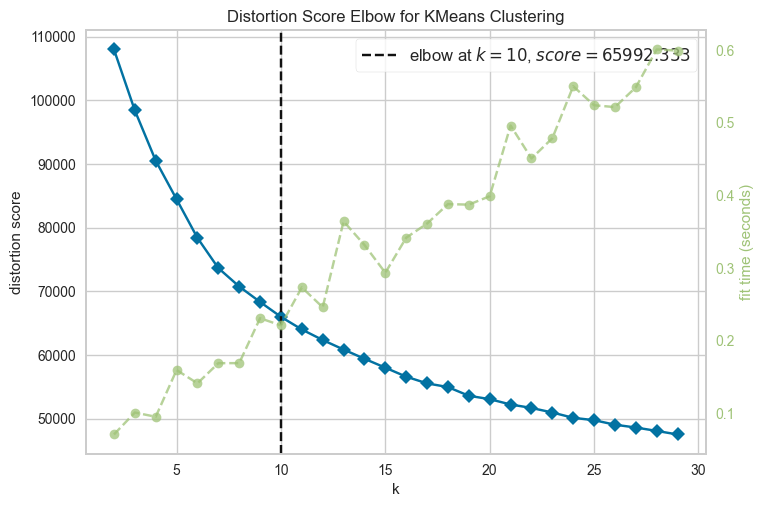

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [41]:
visualizer = KElbowVisualizer(kmeans, k =(2,30))
visualizer.fit(X_prep)
visualizer.show()


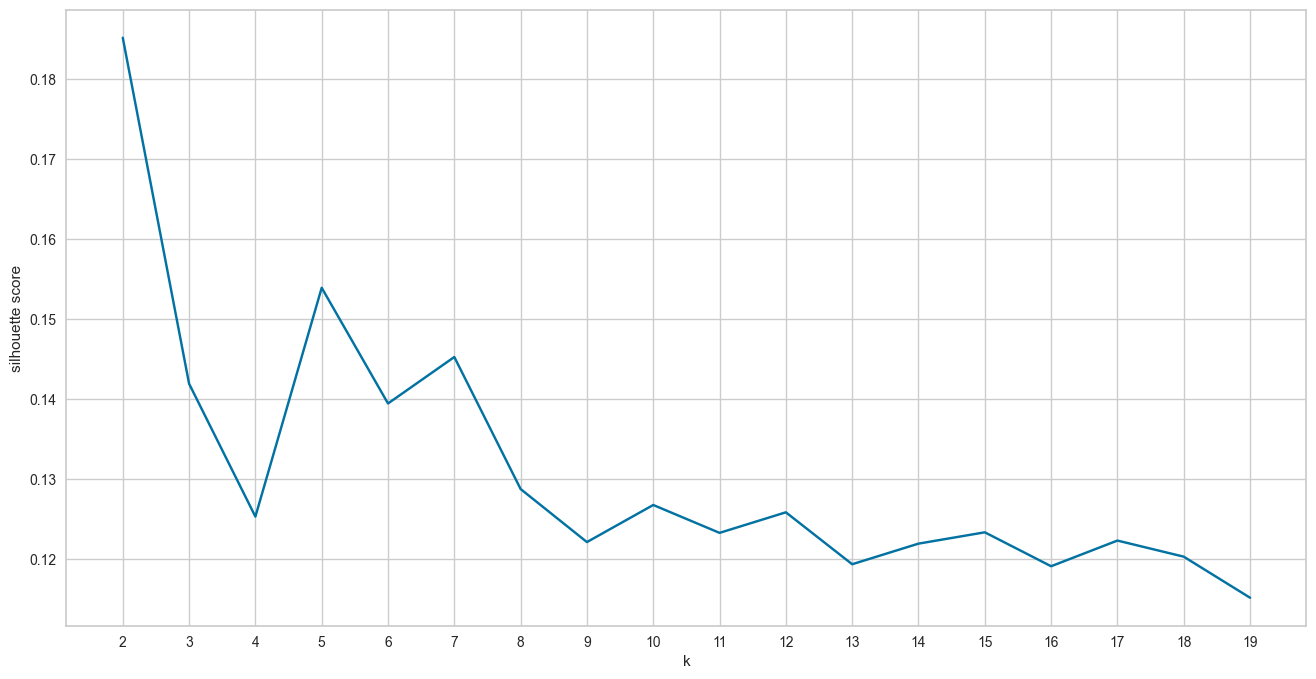

In [42]:
K = range(2, 20)

silhouette = []

for k in K :
    kmeans = KMeans(n_clusters = k, random_state = 42)
    kmeans.fit(X_prep)
    silhouette.append(silhouette_score(X_prep, kmeans.predict(X_prep)))
    
    
plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.show()
    


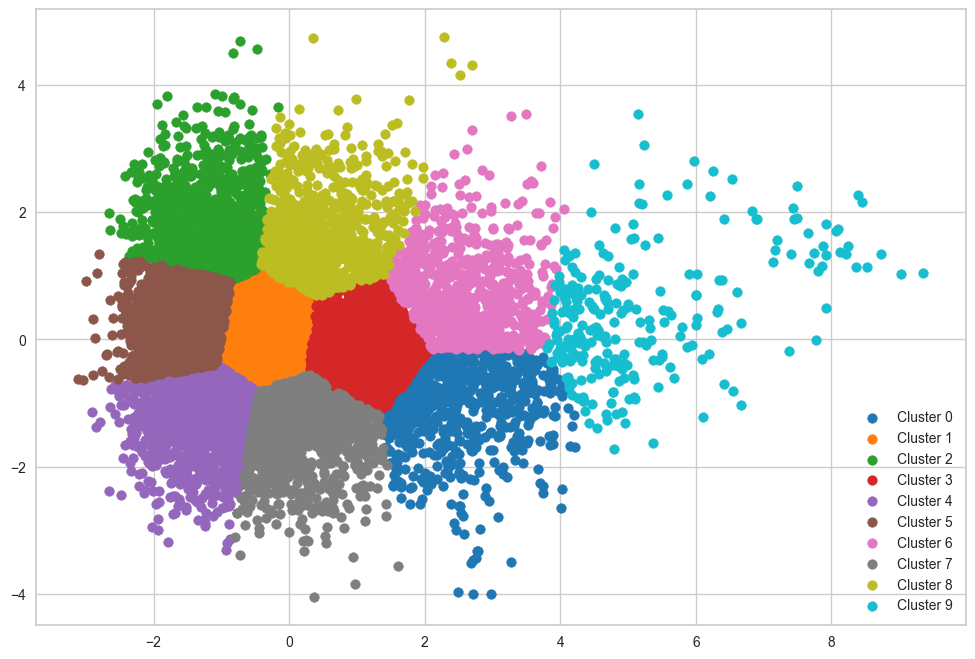

In [43]:
pca = PCA(2)
X_2D = pca.fit_transform(X_prep)

# Perform K-Means clustering with 7 clusters
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(X_2D)

# Get the cluster labels
labels = np.unique(kmeans.labels_)

colors = list(mcolors.TABLEAU_COLORS.values())

# Create a wider figure
plt.figure(figsize=(12, 8))

# Visualize the clusters with custom colors
for i, label in enumerate(labels):
    plt.scatter(X_2D[kmeans.labels_ == label, 0], X_2D[kmeans.labels_ == label, 1], label=f'Cluster {label}', c=colors[i % len(colors)])

plt.legend()
plt.show()

### After evaluating our results from the elbow score and silhouette score, I think 7 clusters is what i will use for the song recommendation. 

In [44]:
X_df.to_csv('spotify_files/kmeans_spot.csv')